# Initialise DB Connections

In [ ]:
import glob
import os
import pickle
import time
from datetime import date, datetime, timedelta

import mysql.connector
import numpy as np
import pandas as pd
import psycopg2
from tqdm import tqdm

# Create new `pandas` methods which use `tqdm` progress bars
# (can use tqdm_gui, optional kwargs, etc.)
# tqdm.pandas()

%load_ext lab_black

# MySQL Connector
mydb = mysql.connector.connect(
    host="****", user="****", password="****", database="****"
)

# Redshift Connector
red = psycopg2.connect(
    dbname="****",
    host="****",
    port="****",
    user="****",
    password="****",
)

red.set_session(readonly=True, autocommit=True)

# Sanity check the ticket message table is available
# May need it updating/one time pull
mycursor = mydb.cursor()
mycursor.execute("Show tables;")
result = mycursor.fetchall()

for x in result:
    print(x)

# Set Constant Variables

In [ ]:
INTERVAL = "MONTH"  # period to pull previous messages (options: DAY, WEEK, MONTH, YEAR)
DELTA = "1"  # how many periods to pull previous messages

# Pull Initial Data From DB's

In [138]:
%%time
starttime = time.time()
tickets = pd.read_sql(
    "SELECT * FROM production.supportpal_ticket_master WHERE messages_count < 4 AND created_at > (CURRENT_DATE - INTERVAL '{}')".format(
        DELTA + " " + INTERVAL
    ),
    red,
)
print(
    "Redshift execution took {:.2f} seconds to pull {} rows".format(
        time.time() - starttime, len(tickets.index)
    )
)

starttime = time.time()

ticket_message = pd.read_sql(
    "SELECT * FROM ticket_message WHERE created_at > UNIX_TIMESTAMP(DATE_SUB(now(), INTERVAL {}))".format(
        DELTA + " " + INTERVAL
    ),
    mydb,
)
print(
    "MySQL execution took {:.2f} seconds ({:.2f} minutes) to pull {} rows".format(
        time.time() - starttime,
        (time.time() - starttime) / 60,
        len(ticket_message.index),
    )
)
print("Formatting MySQL data...")
ticket_message = ticket_message[ticket_message.by == 1]
ticket_message = ticket_message[ticket_message["text"].map(len) < 100000]

print("Merging datasets...")

dataset = pd.merge(tickets, ticket_message, how="inner", on="ticket_id")
print("Initial dataset size: {} rows".format(len(dataset.index)))

print("Initial data pull complete")
print("")

Redshift execution took 5.07 seconds to pull 100603 rows
MySQL execution took 42.90 seconds (0.72 minutes) to pull 99824 rows
Formatting MySQL data...
Merging datasets...
Initial dataset size: 90318 rows
Initial data pull complete

CPU times: user 6.67 s, sys: 1.05 s, total: 7.72 s
Wall time: 48.2 s


# Sample size matching

In [139]:
print("Removing superfluous tags...")

dataset = dataset[dataset.tag_name != "Reviewed"]
dataset = dataset[dataset.tag_name != "No Tag"]
dataset = dataset[dataset.tag_name != "October"]
dataset = dataset[dataset.tag_name != "September"]
dataset = dataset[dataset.tag_name != "BLC_SAR"]
dataset = dataset[dataset.tag_name != "DDS_SAR"]
dataset = dataset[dataset.tag_name != "November"]
dataset = dataset[dataset.tag_name != "Ongoing"]
dataset = dataset.sort_values("created_at_x").groupby("ticket_id").tail(1)
dataset.drop_duplicates(subset=["ticket_number"], inplace=True)
print(len(dataset.index))

print("Formatting tag names...")

dataset["tag_name_formatted"] = dataset["tag_name"].str.replace("BLC_", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("DDS_", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("DDS ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("BLC ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("New ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("new ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("NEW ", "")

print(
    "Most frequent tag name is {}, occuring {} times".format(
        dataset["tag_name_formatted"].value_counts().idxmax(),
        dataset[
            dataset.tag_name_formatted
            == dataset["tag_name_formatted"].value_counts().idxmax()
        ].shape[0],
    )
)

print(
    "Matching other tag sample sizes to {}...".format(
        dataset["tag_name_formatted"].value_counts().idxmax()
    )
)
starttime = time.time()
target_count = dataset[
    dataset.tag_name_formatted == dataset["tag_name_formatted"].value_counts().idxmax()
].shape[0]

category_scaling = pd.read_sql(
    "SELECT * FROM production.supportpal_ticket_master LIMIT 0", red
)

for tag in dataset["tag_name_formatted"].unique():
    current_count = dataset[dataset.tag_name_formatted == tag].shape[0]
    delta = target_count - current_count
    if delta > 0:
        # print("Retrieving {} additional examples of {}".format(delta, tag))

        tickets = pd.read_sql(
            "SELECT * FROM production.supportpal_ticket_master WHERE messages_count < 4 AND tag_name LIKE '%{}%' AND ticket_id NOT IN {} LIMIT {}".format(
                tag, str(tuple(dataset.ticket_id)), delta
            ),
            red,
        )

        frames = [category_scaling, tickets]

        category_scaling = pd.concat(frames)
category_scaling = (
    category_scaling.sort_values("created_at").groupby("ticket_id").tail(1)
)
print(
    "Execution took {:.2f} seconds to pull {} additional rows".format(
        time.time() - starttime, len(category_scaling.index)
    )
)

print("Retrieving ticket messages...")
# print(str(tuple(category_scaling.ticket_id.apply(str))))
starttime = time.time()
ticket_message = pd.read_sql(
    "SELECT * FROM ticket_message WHERE ticket_id IN {}".format(
        str(tuple(category_scaling.ticket_id.apply(str)))
    ),
    mydb,
)
ticket_message = ticket_message[ticket_message.by == 1]
ticket_message = ticket_message[ticket_message["text"].map(len) < 100000]
print(
    "MySQL execution took {:.2f} seconds ({:.2f} minutes) to pull {} rows".format(
        time.time() - starttime,
        (time.time() - starttime) / 60,
        len(ticket_message.index),
    )
)

print("Merging datasets...")

category_scaling = pd.merge(
    category_scaling, ticket_message, how="inner", on="ticket_id"
)
category_scaling.drop_duplicates(subset=["ticket_number"], inplace=True)

print("{} additional rows".format(len(category_scaling.index)))

frames = [dataset, category_scaling]

dataset = pd.concat(frames, axis=0)

print("New dataset size: {} rows".format(len(dataset.index)))

Removing superfluous tags...
18449
Formatting tag names...
Most frequent tag name is non_loggedin_contact_request, occuring 3244 times
Matching other tag sample sizes to non_loggedin_contact_request...
Execution took 25.62 seconds to pull 34880 additional rows
Retrieving ticket messages...
MySQL execution took 13.93 seconds (0.23 minutes) to pull 32149 rows
Merging datasets...
30357 additional rows
New dataset size: 48806 rows


Reformatting tag names...
Tag dataset example sizes
Removing categories that are still too small (less than 1k examples)
Final dataset size: 46017 rows


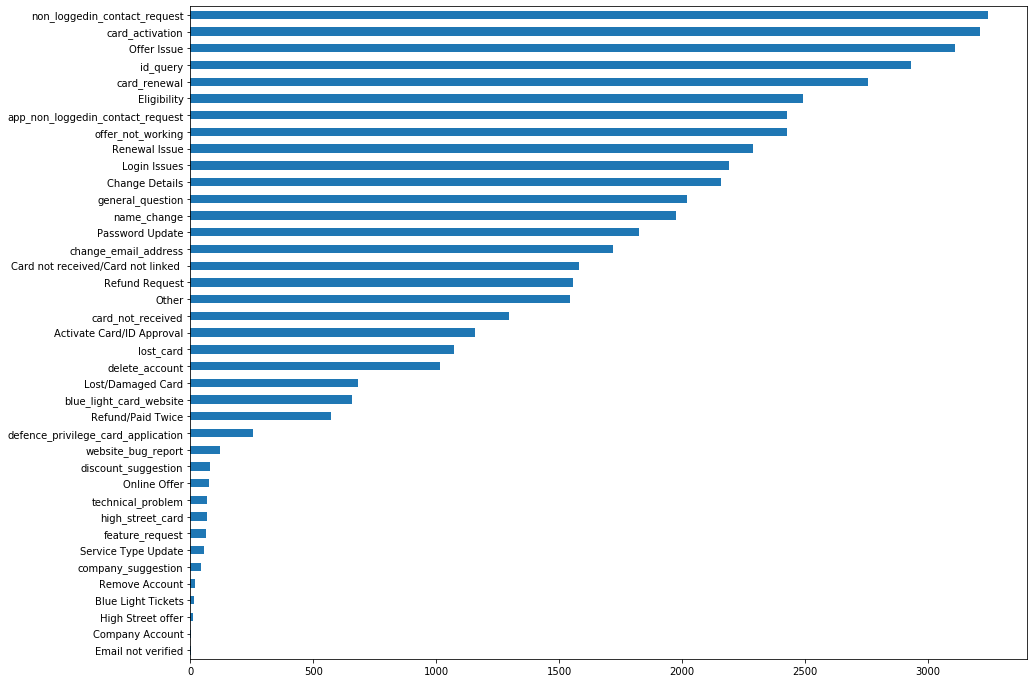

In [140]:
print("Reformatting tag names...")

dataset["tag_name_formatted"] = dataset["tag_name"].str.replace("BLC_", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("DDS_", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("DDS ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("BLC ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("New ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("new ", "")
dataset["tag_name_formatted"] = dataset["tag_name_formatted"].str.replace("NEW ", "")

print("Tag dataset example sizes")
dataset.tag_name_formatted.value_counts().sort_values().plot(
    kind="barh", figsize=(15, 12)
)

print("Removing categories that are still too small (less than 1k examples)")
dataset = dataset.groupby("tag_name_formatted").filter(lambda x: len(x) > 1000)
print("Final dataset size: {} rows".format(len(dataset.index)))

# Data store if needed

As this process is so slow, we can also store the pulled data locally and retrieve it, instead of pulling from the DB everytime

In [141]:
# save the data
dir_path = os.getcwd()
filename = dir_path + "/datastore/message_data_{}.pkl".format(datetime.now())
dataset.to_pickle(filename)
print("Dataset saved to {}".format(filename))

Dataset saved to /home/chris/Documents/Tagging Model/datastore/message_data_2021-12-16 09:48:00.141682.pkl


In [ ]:
# pull the data
dir_path = os.getcwd()
list_of_files = glob.glob(dir_path + "/datastore/message_data_*.pkl")
latest_file = max(list_of_files, key=os.path.getctime)
print("Retrieving most recent dataset from {}".format(latest_file))
dataset = pd.read_pickle(latest_file)
print(len(dataset.index))
dataset.head()

# Data Cleaning/Preprocessing

Define the text preprocessing functions

In [142]:
import re
import string

import nltk
import spacy
from bs4 import BeautifulSoup
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

## These need to be run once in a new environment
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
stop = stopwords.words("english")


def lemmatize_text(text, nlp):
    # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
    # nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(text)
    # Extract the lemma for each token and join
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text


def remove_html(text):
    text = BeautifulSoup(text, features="html.parser").get_text("separator=" " ")
    return text


def remove_punctuation(text):
    # remove all single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    # Substituting multiple spaces with single space
    text = re.sub(r"\s+", " ", text, flags=re.I)
    # Remove all the special characters
    text = re.sub(r"\W", " ", text)
    text = text.lower()
    return text


def remove_emails(text):
    emails = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", text)
    for email in emails:
        text = text.replace(email, "")
    return text


def remove_names(text, nlp):

    doc = nlp(text)
    for token in doc:
        if token.pos_ == "PROPN":
            text = text.replace(token.text, "")
    return text


def process_text(text, nlp):
    # the order here is important for each stage to function correctly
    # if names or punctuation are removed too early, part of speech tagging will not perform as expected
    # if non filtered html text is passed, errors will be raised
    text = remove_html(text)
    text = remove_names(text, nlp)
    text = remove_emails(text)
    text = lemmatize_text(text, nlp)
    text = remove_punctuation(text)
    return text


def count_sentences(text):
    number_of_sentences = sent_tokenize(text)
    return number_of_sentences

[nltk_data] Downloading package stopwords to /home/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chris/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Now apply the text preprocessing. This is an extremely slow process, be patient!

In [144]:
%%time
# tqdm.pandas()
# loading this here to save time within the functions
nlp = spacy.load("en_core_web_sm")
# using the tqdm pandas apply method so we can watch the progress
# dataset['text_formatted'] = dataset['text'].progress_apply(process_text, nlp=nlp)
dataset["text_formatted"] = dataset["text"].apply(process_text, nlp=nlp)

print("Text format complete")
print("Storing the output")
# save the data
dir_path = os.getcwd()
filename = dir_path + "/datastore/message_data_processed_text_{}.pkl".format(
    datetime.now()
)
dataset.to_pickle(filename)
print("Dataset saved to {}".format(filename))

Text format complete
Storing the output
Dataset saved to /home/chris/Documents/Tagging Model/datastore/message_data_processed_text_2021-12-16 10:11:29.233511.pkl
CPU times: user 23min 27s, sys: 214 ms, total: 23min 27s
Wall time: 23min 28s


In [ ]:
# pull the data
dir_path = os.getcwd()
list_of_files = glob.glob(dir_path + "/datastore/message_data_processed_text_*.pkl")
latest_file = max(list_of_files, key=os.path.getctime)
print("Retrieving most recent dataset from {}".format(latest_file))
dataset = pd.read_pickle(latest_file)
dataset.head()


# Text / NLP based features

A number of extra text based features can also be created which sometimes are helpful for improving text classification models. Some examples are:

    Word Count of the documents – total number of words in the documents
    Character Count of the documents – total number of characters in the documents
    Average Word Density of the documents – average length of the words used in the documents
    Puncutation Count in the Complete Essay – total number of punctuation marks in the documents
    Upper Case Count in the Complete Essay – total number of upper count words in the documents
    Title Word Count in the Complete Essay – total number of proper case (title) words in the documents
    Frequency distribution of Part of Speech Tags:
        Noun Count
        Verb Count
        Adjective Count
        Adverb Count
        Pronoun Count

These features are highly experimental ones and should be used according to the problem statement only.


In [ ]:
dataset["char_count"] = dataset["text"].apply(len)
dataset["word_count"] = dataset["text"].apply(lambda x: len(x.split()))
dataset["word_density"] = dataset["char_count"] / (dataset["word_count"] + 1)
dataset["punctuation_count"] = dataset["text"].apply(
    lambda x: len("".join(_ for _ in x if _ in string.punctuation))
)
dataset["title_word_count"] = dataset["text"].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.istitle()])
)
dataset["upper_case_word_count"] = dataset["text"].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.isupper()])
)

In [ ]:
pos_family = {
    "noun": ["NN", "NNS", "NNP", "NNPS"],
    "pron": ["PRP", "PRP$", "WP", "WP$"],
    "verb": ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    "adj": ["JJ", "JJR", "JJS"],
    "adv": ["RB", "RBR", "RBS", "WRB"],
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt


dataset["noun_count"] = dataset["text"].apply(lambda x: check_pos_tag(x, "noun"))
dataset["verb_count"] = dataset["text"].apply(lambda x: check_pos_tag(x, "verb"))
dataset["adj_count"] = dataset["text"].apply(lambda x: check_pos_tag(x, "adj"))
dataset["adv_count"] = dataset["text"].apply(lambda x: check_pos_tag(x, "adv"))
dataset["pron_count"] = dataset["text"].apply(lambda x: check_pos_tag(x, "pron"))

# Topic Modelling

In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.

In [ ]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(
    n_components=20, learning_method="online", max_iter=20
)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][
        : -(n_top_words + 1) : -1
    ]
    topic_summaries.append(" ".join(topic_words))

# Model Building

First, remove unused columns, focus on those that will be used as features

In [148]:
dataset = dataset[
    [
        "brand_id",
        "channel_id_x",
        "department_id",
        "tag_name_formatted",
        "text_formatted",
    ]
]
dataset.head()

,brand_id,channel_id_x,department_id,tag_name_formatted,text_formatted
6026,1,3,4,Login Issues,sender do not click link or attachment unless...
1,1,3,4,non_loggedin_contact_request,face panose face family panose style p div fa...
37,1,3,4,Card not received/Card not linked,face panose face family panose style p div ma...
3,1,3,4,card_activation,hi not work device manufacturer os
6146,1,3,4,Login Issues,margin top margin bottom sndr do not click li...


Split the data into input and target variables and split to train and test sets

In [150]:
X = dataset.loc[:, dataset.columns != "tag_name_formatted"]
y = dataset["tag_name_formatted"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

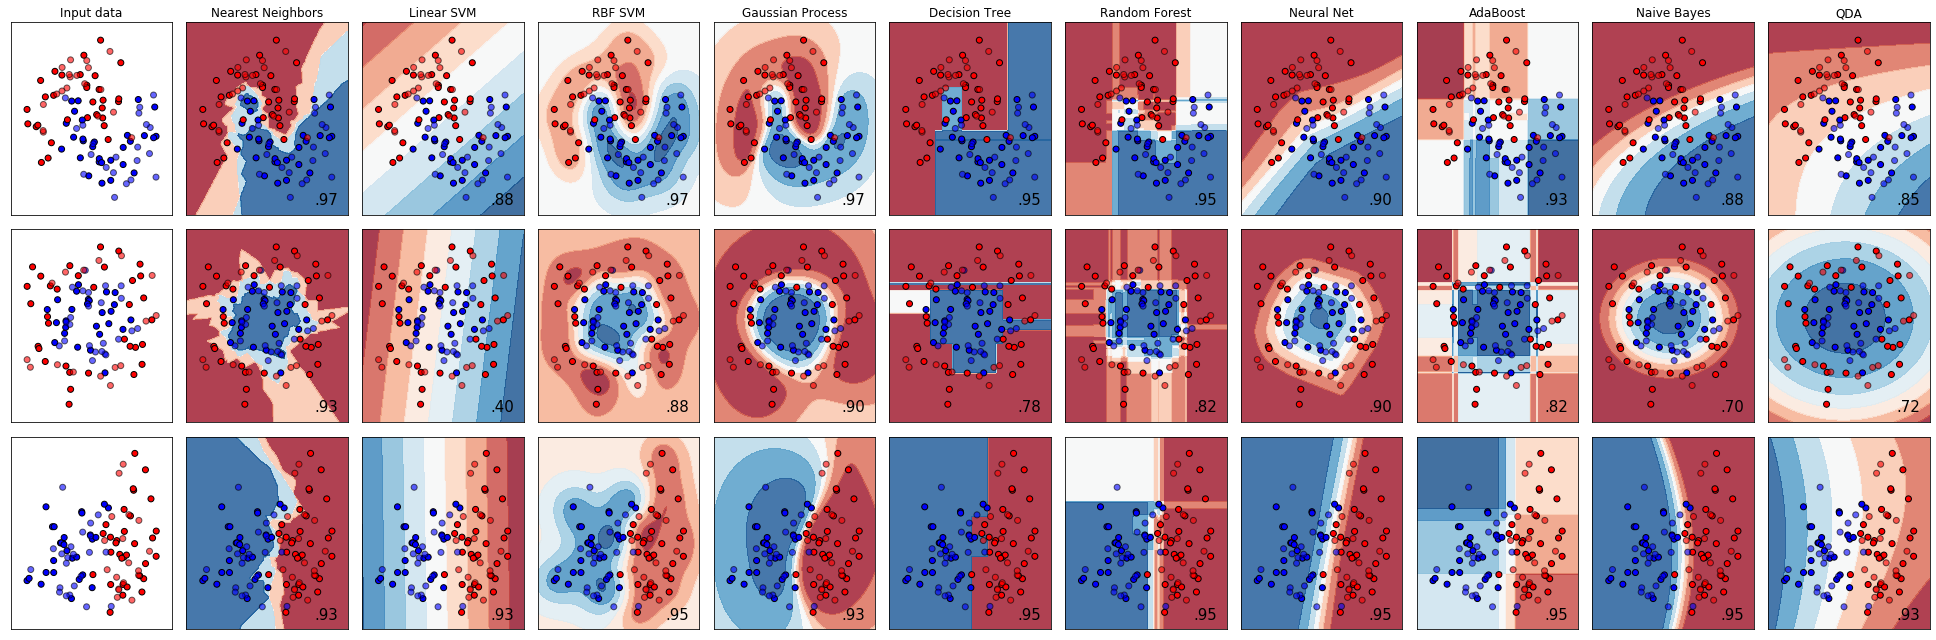

In [ ]:
tickets = pd.read_sql(
    "SELECT DISTINCT tag_name FROM production.supportpal_ticket_master WHERE messages_count < 4 AND created_at > (CURRENT_DATE - INTERVAL '{}')".format(
        DELTA + " " + INTERVAL
    ),
    red,
)

tickets